In [1]:
import os
import sys
import pandas as pd
#import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
# Build an absolute path from this notebook's parent directory
module_path = os.path.abspath(os.path.join('..', 'src'))
print(module_path)
# Add to sys.path if not already present
if module_path not in sys.path:
    sys.path.append(module_path)
print(module_path)
# Now you can import the desired function or class
#from clean_df import *
from graph_helpers import *
from helpers import *
from mod_si import *
from plots import *
from find_net_stats import *

/nfs/nfs9/home/nobackup/vakrao/nz_model/src
/nfs/nfs9/home/nobackup/vakrao/nz_model/src


In [2]:
# 1000 plants, E0/plant_run/plant_run.csv
year_lin = "../src/Y_C/Y_C_lin_Y_D.csv"
seas_lin = "../src/S_C/S_C_lin_S_D.csv"
month_lin = "../src/M_C/M_C_lin_M_D.csv"
real_inc_fp,window_inc_fp  = "../params/new_psa.csv","../params/window_psa.csv"
post_fp = "static_post.csv"
params = "lin"
calib_shift = False
R = .01
ylin_dat = pd.read_csv(year_lin)
slin_dat = pd.read_csv(seas_lin)
mlin_dat = pd.read_csv(month_lin)
all_m = mlin_dat.drop_duplicates().reset_index()
all_s = slin_dat.drop_duplicates().reset_index()
all_y = ylin_dat.drop_duplicates().reset_index()

### Graph Visualization Parameters ###

In [3]:
line_x,line_y, = 20,40
tick_fs = 15
font = {'size': 10}
#months_all = ["02/11","03/11","04/11","05/11","06/11","07/11","08/11","09/11","10/11","11/11","12/11","1/12","2/12","3/12"]
months = ["","Mar/11","May/11","Jul/11","Sep/11","Nov/11","Jan/12","Mar/12"]
# using rc function
plt.rc('font', **font)
eps = 30
pct = 0.8
real_inc_fp = "../params/new_psa.csv"
window_inc_fp = "../params/window_psa.csv"

In [4]:
## real values ##
month_real = find_best_config(all_m,real_inc_fp,"M",eps,pct)
season_real = find_best_config(all_s,real_inc_fp,"S",eps,pct)
year_real = find_best_config(all_y,real_inc_fp,"Y",eps,pct)
## smoothened values ## 
month_smooth = find_best_config(all_m,window_inc_fp,"M",eps,pct)
season_smooth = find_best_config(all_s,window_inc_fp,"S",eps,pct)
year_smooth = find_best_config(all_y,window_inc_fp,"Y",eps,pct)

In [5]:
best_month = month_real
best_season = season_real
best_year = year_real
all_best = {"Monthly":best_month,"Seasonal":best_season,"Yearly":best_year} 
min_rmse = 10000
best_config = ()
best_agg = ""
# we save the absolute best_RMSE value
for a in all_best:
    best_type = all_best[a]
    if best_type["RMSE"] < min_rmse:
        best_config = best_type["inc"]
        min_rmse = best_type["RMSE"]
        best_agg = a    

In [6]:
real_inc = pd.read_csv(real_inc_fp)
real_inc = list(real_inc["Delta Orchard"])
window_inc = pd.read_csv(window_inc_fp)
window_inc = list(window_inc["Delta Orchard"])

In [7]:
m_real_rob = filter_large_df(all_m,month_real["b_b"],month_real["b_w"],month_real["D"])
m_smooth_rob = filter_large_df(all_m,month_smooth["b_b"],month_smooth["b_w"],month_smooth["D"])
s_real_rob = filter_large_df(all_s,season_real["b_b"],season_real["b_w"],season_real["D"])
s_smooth_rob = filter_large_df(all_s,season_smooth["b_b"],season_smooth["b_w"],season_smooth["D"])
y_real_rob = filter_large_df(all_y,year_real["b_b"],year_real["b_w"],year_real["D"])
y_smooth_rob = filter_large_df(all_y,year_smooth["b_b"],year_smooth["b_w"],year_smooth["D"])

In [8]:
# get all viable configs
# across all paramters 
def find_all_value(full_data,real_inc,eps,pct):
    # for each seed
    # find RMSE distribution
    grouped_dat  = full_data.groupby(["b_w","b_b","shift","alpha","seed","D"])
    seed_rmse = []
    mean_inc = []
    seed_configs = {}
    counter = 0
    all_inc = []
    all_seeds = 0
    for name,group in grouped_dat:
        
        param_cuml = list(group['monthly_cuml'])
        b_w = float(name[0])
        b_b =float(name[1])
        L = float(name[2])
        alpha = float(name[3])
        seed = float(name[4])
        D = float(name[5])
        #param_cuml = param_cuml[1:]
        param_inc = calc_month_incidence(param_cuml)
        
        if len(param_inc) < 13:
            continue
        if len(mean_inc) == 0:
            mean_inc = [0 for i in range(0,len(param_inc))]
        if filter_seeds(param_inc,real_inc,eps,pct) == True:
            for i,p in enumerate(param_inc):
                mean_inc[i] += p
            seed_configs[counter] = param_inc
            counter += 1
        all_seeds += 1
   
    for i,p in enumerate(mean_inc):
        mean_inc[i] = p/(counter)
    return mean_inc,seed_configs

In [9]:
def find_out_prob(full_data,inc,eps,pct):
    # for each seed
    # find RMSE distribution
    grouped_dat  = full_data.groupby(["b_w","b_b","shift","alpha","seed","D"])
    seed_rmse = []
    mean_inc = []
    seed_configs = {}
    counter = 0
    all_inc = []
    all_configs = 0
    good_seeds,all_seeds = set(),set()
    for name,group in grouped_dat:
        
        param_cuml = list(group['monthly_cuml'])
        b_w = float(name[0])
        b_b =float(name[1])
        L = float(name[2])
        alpha = float(name[3])
        seed = float(name[4])
        D = float(name[5])
        #param_cuml = param_cuml[1:]
        param_inc = calc_month_incidence(param_cuml)
        
        if len(param_inc) < 13:
            continue
        if len(mean_inc) == 0:
            mean_inc = [0 for i in range(0,len(param_inc))]
        if filter_seeds(param_inc,inc,eps,pct) == True:
            counter += 1
            good_seeds.add(seed)
        all_configs += 1
        all_seeds.add(seed)
    prob_out = (counter/all_configs)*100
    prob_seed = len(good_seeds)/len(all_seeds)
    return prob_out
def find_seed_prob(f_d,inc,eps,pct):
    g_d = f_d.groupby(["b_w","b_b","shift","alpha","seed","D"])
    seed_rmse = []
    mean_inc = []
    seed_configs = {}
    counter = 0
    all_inc = []
    all_seeds = 0
    good_seeds = set()
    all_seeds = set()
    for name,group in g_d:
        
        param_cuml = list(group['monthly_cuml'])
        b_w = float(name[0])
        b_b =float(name[1])
        L = float(name[2])
        alpha = float(name[3])
        seed = float(name[4])
        D = float(name[5])
        #param_cuml = param_cuml[1:]
        param_inc = calc_month_incidence(param_cuml)
        
        if len(param_inc) < 13:
            continue
        if len(mean_inc) == 0:
            mean_inc = [0 for i in range(0,len(param_inc))]
        if filter_seeds(param_inc,inc,eps,pct) == True:
            good_seeds.add(seed)
        all_seeds.add(seed)
    
    filter_prob = (len(good_seeds)/len(all_seeds))*100
    return filter_prob
    

In [10]:
def save_seeds(f_d,inc,inc_type,dat_type,eps,pct):
    g_d = f_d.groupby(["b_w","b_b","shift","alpha","seed","D"])
    seed_rmse = []
    mean_inc = []
    seed_configs = {}
    counter = 0
    all_inc = []
    all_seeds = 0
    good_seeds = set()
    all_seeds = set()
    for name,group in g_d:
        
        param_cuml = list(group['monthly_cuml'])
        b_w = float(name[0])
        b_b =float(name[1])
        L = float(name[2])
        alpha = float(name[3])
        seed = float(name[4])
        D = float(name[5])
        param_cuml = param_cuml[1:]
        param_inc = calc_month_incidence(param_cuml)
        
        if len(param_inc) < 13:
            continue
        if len(mean_inc) == 0:
            mean_inc = [0 for i in range(0,len(param_inc))]
        if filter_seeds(param_inc,inc,eps,pct) == True:
            good_seeds.add(seed)
        all_seeds.add(seed)
    
    seed_data = pd.DataFrame()
    seed_data["good_seeds"] = list(good_seeds)
    save_name = dat_type+"_"+inc_type+".csv"
    seed_data.to_csv(save_name)
    return 

In [11]:
## find probability that config is in the filtered range 
# depending on data type
eps,pct = 30,.8
yr_op = find_out_prob(all_y,real_inc,eps,pct)
sr_op = find_out_prob(all_s,real_inc,eps,pct)
mr_op = find_out_prob(all_m,real_inc,eps,pct)
ys_op = find_out_prob(all_y,window_inc,eps,pct)
ss_op = find_out_prob(all_s,window_inc,eps,pct) 
ms_op = find_out_prob(all_m,window_inc,eps,pct)

In [22]:
## find probability that config is in the filtered range 
# depending on data type
yr_sp = find_seed_prob(y_real_rob,real_inc,eps,pct)
sr_sp = find_seed_prob(s_real_rob,real_inc,eps,pct)
mr_sp = find_seed_prob(m_real_rob,real_inc,eps,pct)
ys_sp = find_seed_prob(y_smooth_rob,window_inc,eps,pct)
ss_sp = find_seed_prob(s_smooth_rob,window_inc,eps,pct) 
ms_sp = find_seed_prob(m_smooth_rob,window_inc,eps,pct)

In [23]:
save_seeds(s_real_rob,real_inc,"real","seasonal",eps,pct)

In [24]:
# real_op,smooth_op: real smooth outbreak probability 
# real_sp,smooth_sp: real seed probability, smooth seed probability
real_op = {"Year":yr_op,"Season":sr_op,"Month":mr_op}
real_sp = {"Year":yr_sp,"Season":sr_sp,"Month":mr_sp}
smooth_op = {"Year":ys_op,"Season":ss_op,"Month":ms_op}
smooth_sp = {"Year":ys_sp,"Season":ss_sp,"Month":ms_sp}

In [25]:
def find_min_max_seed_range(seed_configs):
    min_val,max_val = [],[]
    inc_obsvs = len(seed_configs[0])
    min_val = [[] for i in range(0,inc_obsvs)]
    max_val = [[] for i in range(0,inc_obsvs)]
    for s in seed_configs:
        for i,value in enumerate(seed_configs[s]):
            min_val[i].append(value)
            max_val[i].append(value)
    min_err = [min(v) for v in min_val][0:]
    max_err = [max(v) for v in min_val][0:]
    return min_err,max_err

In [26]:
# real values
mean_s,real_season_c = find_all_value(s_real_rob,real_inc,eps,pct)
mean_m,real_month_c = find_all_value(m_real_rob,real_inc,eps,pct)
mean_y,real_year_c = find_all_value(y_real_rob,real_inc,eps,pct)
# real band
min_s_rerr,max_s_rerr = find_min_max_seed_range(real_season_c)
min_m_rerr,max_m_rerr = find_min_max_seed_range(real_month_c)
min_y_rerr,max_y_rerr = find_min_max_seed_range(real_year_c)

In [27]:
# smooth values 
mean_s,smooth_season_c = find_all_value(s_smooth_rob,window_inc,eps,pct)
mean_m,smooth_month_c = find_all_value(m_smooth_rob,window_inc,eps,pct)
mean_y,smooth_year_c = find_all_value(y_smooth_rob,window_inc,eps,pct)
# smooth errors
min_s_serr,max_s_serr = find_min_max_seed_range(smooth_season_c)
min_m_serr,max_m_serr = find_min_max_seed_range(smooth_month_c)
min_y_serr,max_y_serr = find_min_max_seed_range(smooth_year_c)

In [31]:
config_names = [r'Viable Configurations',r'Best-Fit Seeds']
probabilties_real = {
    config_names[0]:[real_op["Year"],real_op["Season"],real_op["Month"]],
    config_names[1]:[real_sp["Year"],real_sp["Season"],real_sp["Month"]]
}
probabilties_smooth = {
    config_names[0]:[smooth_op["Year"],smooth_op["Season"],smooth_op["Month"]],
    config_names[1]:[smooth_sp["Year"],smooth_sp["Season"],smooth_sp["Month"]]
}

In [34]:
print(year_real)
print(season_real)
print(month_real)

{'b_b': 0.04, 'b_w': 0.07, 'L': 3.0, 'D': 0.8, 'seed': 10322.0, 'RMSE': 78.26, 'inc': [1.0, 1.0, 0.0, 0.0, 6.0, 15.0, 92.0, 132.0, 185.0, 273.0, 186.0, 144.0, 114.0, 86.0], 'total': [1.0, 2.0, 2.0, 2.0, 8.0, 23.0, 115.0, 247.0, 432.0, 705.0, 891.0, 1035.0, 1149.0, 1235.0], 'agg': 'Y'}
{'b_b': 0.03, 'b_w': 0.08, 'L': 3.0, 'D': 0.8, 'seed': 21729.0, 'RMSE': 65.83, 'inc': [2.0, 0.0, 2.0, 20.0, 58.0, 57.0, 89.0, 70.0, 103.0, 307.0, 153.0, 106.0, 195.0, 57.0], 'total': [2.0, 2.0, 4.0, 24.0, 82.0, 139.0, 228.0, 298.0, 401.0, 708.0, 861.0, 967.0, 1162.0, 1219.0], 'agg': 'S'}
{'b_b': 0.03, 'b_w': 0.09, 'L': 3.0, 'D': 0.4, 'seed': 8878.0, 'RMSE': 75.87, 'inc': [2.0, 1.0, 3.0, 12.0, 22.0, 47.0, 73.0, 111.0, 178.0, 309.0, 198.0, 130.0, 156.0, 153.0], 'total': [2.0, 3.0, 6.0, 18.0, 40.0, 87.0, 160.0, 271.0, 449.0, 758.0, 956.0, 1086.0, 1242.0, 1395.0], 'agg': 'M'}


In [35]:
print(year_smooth)
print(season_smooth)
print(month_smooth)

{'b_b': 0.02, 'b_w': 0.1, 'L': 3.0, 'D': 0.4, 'seed': 21606.0, 'RMSE': 41.35, 'inc': [2.0, 1.0, 1.0, 3.0, 6.0, 24.0, 45.0, 72.0, 157.0, 241.0, 195.0, 135.0, 99.0, 59.0], 'total': [2.0, 3.0, 4.0, 7.0, 13.0, 37.0, 82.0, 154.0, 311.0, 552.0, 747.0, 882.0, 981.0, 1040.0], 'agg': 'Y'}
{'b_b': 0.03, 'b_w': 0.07, 'L': 3.0, 'D': 0.8, 'seed': 21719.0, 'RMSE': 43.21, 'inc': [1.0, 1.0, 0.0, 11.0, 28.0, 49.0, 94.0, 76.0, 105.0, 244.0, 198.0, 105.0, 156.0, 125.0], 'total': [1.0, 2.0, 2.0, 13.0, 41.0, 90.0, 184.0, 260.0, 365.0, 609.0, 807.0, 912.0, 1068.0, 1193.0], 'agg': 'S'}
{'b_b': 0.02, 'b_w': 0.1, 'L': 3.0, 'D': 0.4, 'seed': 21709.0, 'RMSE': 41.23, 'inc': [1.0, 0.0, 1.0, 3.0, 14.0, 55.0, 84.0, 122.0, 151.0, 273.0, 230.0, 124.0, 123.0, 136.0], 'total': [1.0, 1.0, 2.0, 5.0, 19.0, 74.0, 158.0, 280.0, 431.0, 704.0, 934.0, 1058.0, 1181.0, 1317.0], 'agg': 'M'}


/tmp/ipykernel_312821/1476309980.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(months)
/tmp/ipykernel_312821/1476309980.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_312821/1476309980.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(months)
/tmp/ipykernel_312821/1476309980.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


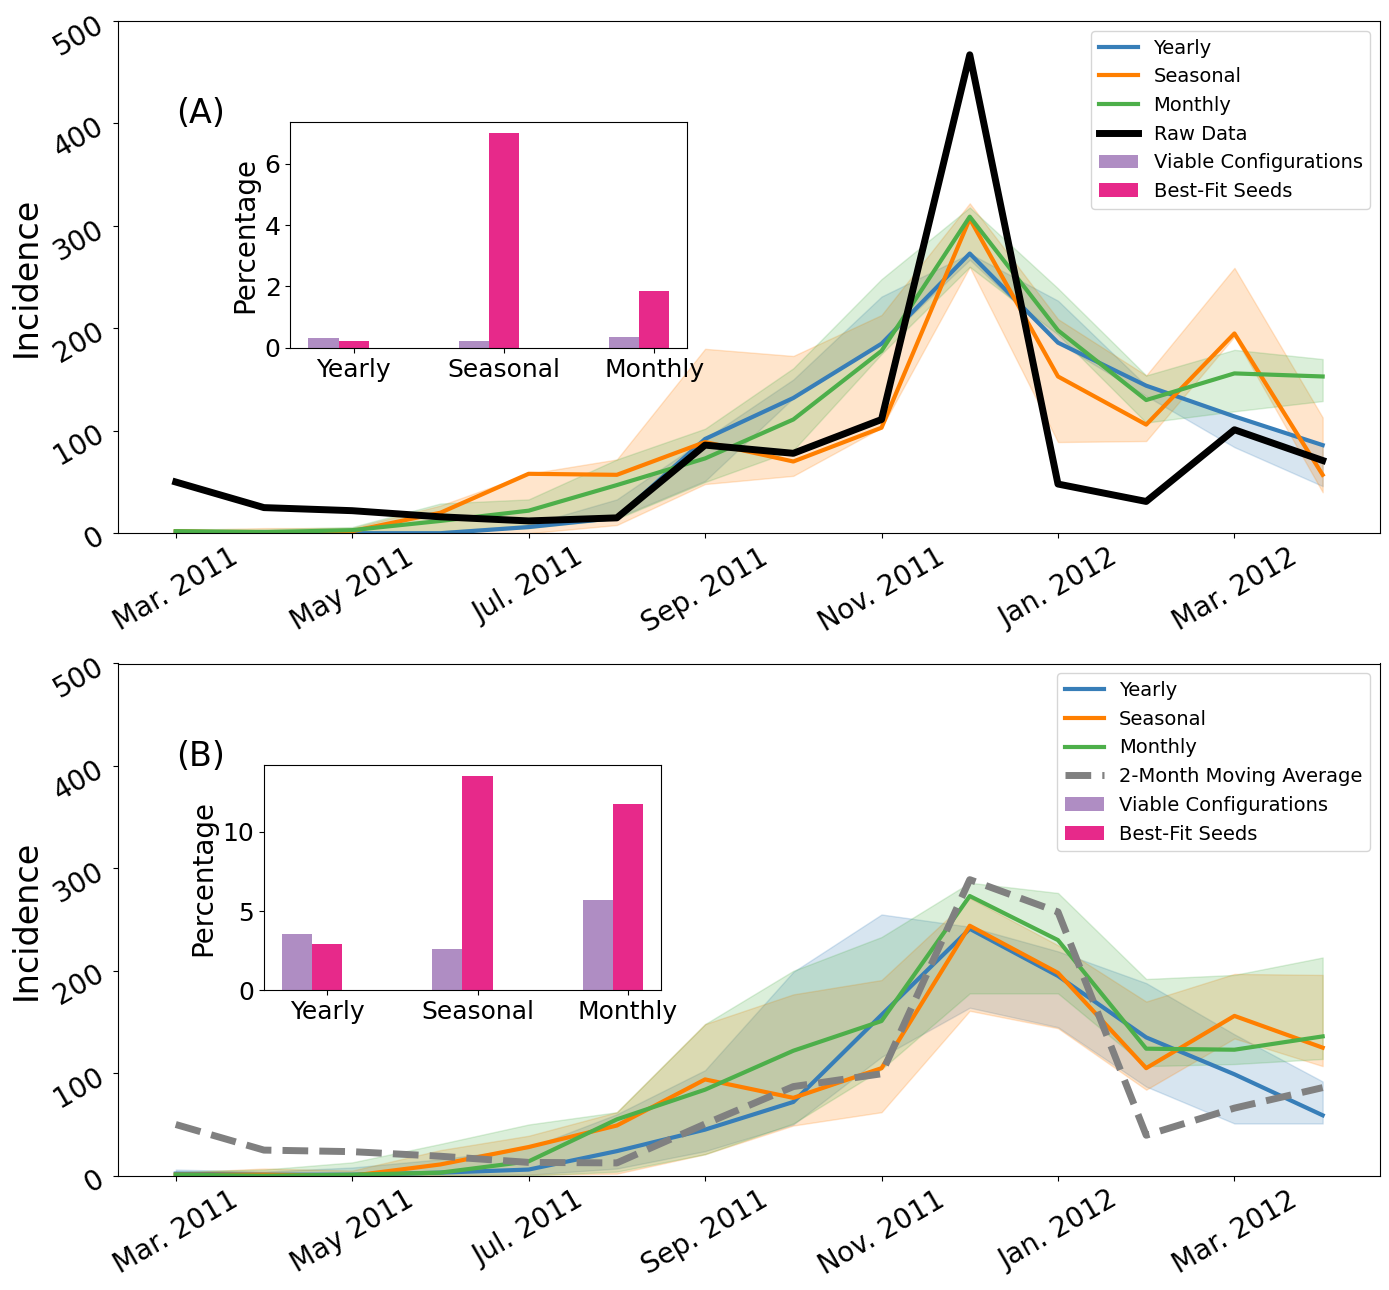

In [64]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
colors = ["#377eb8","#ff7f00","#4daf4a"]
bar_colors = {config_names[0]:"#af8dc3",config_names[1]:"#e7298a"}
temp_types = ["Yearly","Seasonal","Monthly"]
#months_all = ["MAR/11","APR/11","MAY/11","JUN/11","JUL/11","AUG/11","SEP/11","OCT/11","NOV/11","DEC/11","JAN/12","FEB/12","MAR/12"]
months = ["","Mar. 2011","May 2011","Jul. 2011","Sep. 2011","Nov. 2011","Jan. 2012","Mar. 2012"]

fig_x,fig_y = 14,13
fig,axs = plt.subplots(2,1,figsize=(fig_x,fig_y),sharey=True)
ms,ls = 12,20
annot_fs = 24
sup_font = 24
raw_lab = "Raw Data"
ma_lab = "2-Month Moving Average"


lw,inc_lw = 3,5
leg_fs = 14
tick_angle = 30
ins_sz = 16
mark_type = "o"
lab_coords = (0,400)
offset,width = 2,0.2
# now start to graph
axs[0].annotate("(A)",lab_coords,size=annot_fs,annotation_clip=False)
axs[0].tick_params(labelsize=ls,rotation=tick_angle)

axs[0].plot(year_real["inc"],color=colors[0],markersize=ms,linewidth=lw,label="Yearly")
axs[0].plot(best_config,color=colors[1],markersize=ms,linewidth=lw,label="Seasonal")
axs[0].plot(month_real["inc"],color=colors[2],markersize=ms,linewidth=lw,label="Monthly")
axs[0].set_xticklabels(months)

axs[0].plot(real_inc,color="k",linewidth=inc_lw,label=raw_lab,markersize=ms)
ins_ax0 = inset_axes(axs[0], width="45%", height="55%", bbox_to_anchor=(1.3, 1, 10, 400),
                    bbox_transform=axs[0].transData, loc="upper left", borderpad=0)
multiplier = 0
x = np.arange(len(list(real_op.keys()))) 
for attr,measure in probabilties_real.items():
    offset = width * multiplier
    if attr == config_names[0]:
        alpha = 0.1
    if attr == config_names[1]:
        alpha = 1
    rects = ins_ax0.bar(x + offset, measure, width,color=bar_colors[attr],label=attr)
 
    #ins_ax0.bar_label(rects, padding=3)
    multiplier += 1
    #ins_ax0.bar(list(real_op.keys()),list(real_op.values()),alpha=alpha,color=colors)

ins_ax0.set_xticks(x + width, temp_types)
ins_ax0.tick_params(labelsize=18)
fig.tight_layout()

#ins_ax0.legend(bbox_to_anchor=(.6, 1.4))
ins_y_fs = 20
ins_ax0.set_ylabel("Percentage",size=ins_y_fs)
axs[0].fill_between(range(len(mean_y)), min_y_rerr, max_y_rerr, color=colors[0], alpha=0.2)
axs[0].fill_between(range(len(mean_s)), min_s_rerr, max_s_rerr, color=colors[1], alpha=0.2)
axs[0].fill_between(range(len(mean_m)), min_m_rerr, max_m_rerr, color=colors[2], alpha=0.2)



axs[1].tick_params(labelsize=ls,rotation=tick_angle)
axs[1].annotate("(B)",lab_coords,size=annot_fs,annotation_clip=False)

axs[1].plot(year_smooth["inc"],color=colors[0],markersize=ms,label="Yearly",linewidth=lw)
axs[1].plot(season_smooth["inc"],color=colors[1],markersize=ms,label="Seasonal",linewidth=lw)
axs[1].plot(month_smooth["inc"],color=colors[2],markersize=ms,label="Monthly",linewidth=lw)

axs[1].plot(window_inc,color="grey",ls="--",linewidth=inc_lw,label=ma_lab,markersize=ms)
axs[1].fill_between(range(len(mean_y)), min_y_serr, max_y_serr, color=colors[0], alpha=0.2)
axs[1].fill_between(range(len(mean_s)), min_s_serr, max_s_serr, color=colors[1], alpha=0.2)
axs[1].fill_between(range(len(mean_m)), min_m_serr, max_m_serr, color=colors[2], alpha=0.2)

axs[1].set_xticklabels(months)

ins_ax1 = inset_axes(axs[1], width="45%", height="55%", bbox_to_anchor=(1, 1, 10, 400),
                    bbox_transform=axs[1].transData, loc="upper left", borderpad=0)  # [x, y, width, height] w.r.t. fig
multiplier = 0
x = np.arange(len(list(real_op.keys()))) 
for attr,measure in probabilties_smooth.items():
    offset = width * multiplier
    if attr == "P":
        alpha = 0.1
    if attr == "P[Seed]":
        alpha = 1
    rects = ins_ax1.bar(x + offset, measure, width,color=bar_colors[attr],label=attr)

    #ins_ax0.bar_label(rects, padding=3)
    multiplier += 1
    #ins_ax0.bar(list(real_op.keys()),list(real_op.values()),alpha=alpha,color=colors)
ins_ax1.set_xticks(x + width, temp_types)
#ins_ax1.legend(bbox_to_anchor=(.6, 1.4))
#ins_ax1.legend(loc='upper left', ncols=3)
ins_ax1.set_ylabel("Percentage",size=20)
ins_ax1.tick_params(labelsize=18)

# Get handles and labels from both axes
handles_ax0, labels_ax0 = axs[0].get_legend_handles_labels()
handles_ax1, labels_ax1 = axs[1].get_legend_handles_labels()

handles_inset, labels_inset = ins_ax0.get_legend_handles_labels()

# 3. Combine them
all_handles = handles_main + handles_ax0
all_labels = labels_main + labels_ax1

h_ax0 = handles_ax0  + handles_inset
l_ax0 = labels_ax0 +labels_inset

h_ax1 = handles_ax1 + handles_inset
l_ax1 = labels_ax1+labels_inset

# 4. Create the combined legend on the main axes
axs[0].legend(h_ax0, l_ax0,fontsize=leg_fs,loc="upper right")
axs[1].legend(h_ax1, l_ax1,fontsize=leg_fs,loc="upper right")

#axs[0].legend(fontsize=14,)
axs[0].set_ylim([0,500])
axs[1].set_ylim([0,500])

axs[0].set_ylabel("Incidence",fontsize=sup_font)
axs[1].set_ylabel("Incidence",fontsize=sup_font)
#fig.supxlabel("Time",fontsize=sup_font)
fig.tight_layout()
fig.savefig("figs/best-fit.png")